<a href="https://colab.research.google.com/github/Danny-Dasilva/Lego_Gen/blob/main/Notebooks/EfficientNetB0_Retrain_PostTrainingQuantization_Lego.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install tensorflow-gpu==2.3.0
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)
!nvidia-smi -L

Found GPU at: /device:GPU:0
2.3.0
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-10f6d762-c6bd-6e57-aa15-fa1fde4d1f09)


In [6]:
import os     
import numpy as np
import pandas as pd
from tensorflow import keras
import pathlib
from keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

In [13]:
%cd /content/
!wget https://github.com/Danny-Dasilva/Lego_Gen/releases/download/0.0.1/images.tgz
!tar xvf images.tgz

/content
--2021-01-07 10:24:25--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 64.233.166.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M  54.3MB/s    in 4.0s    

2021-01-07 10:24:30 (54.3 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.j

In [3]:
flowers_dir  = '/content/images'
NUM_CLASSES   = 9
classes = ['0','1','2','3','4', '5', '6', '7', '8']

In [24]:
IMAGE_SIZE = 224
BATCH_SIZE = 64

datagen = ImageDataGenerator(rescale=1/255.,
                             validation_split=0.15)

train_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='training')

val_generator = datagen.flow_from_directory(
    flowers_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    subset='validation')

Found 3123 images belonging to 5 classes.
Found 547 images belonging to 5 classes.


In [25]:
batch_images, batch_labels = next(val_generator)

In [26]:
batch_labels

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1.

In [51]:
# Creates label file
!mkdir /content/model
labels = '\n'.join(sorted(train_generator.class_indices.keys()))
with open('/content/model/image_labels.txt', 'w') as f:
  f.write(labels)
with open('/content/model/image_labels.txt', 'r') as f:
  labels = [line.strip() for line in f.readlines()]
print(labels)

mkdir: cannot create directory ‘/content/model’: File exists
['2780', '3004', '3023', '3024', '3069b', '3710', '4073', '54200', '98138']


In [52]:
len(labels)

9

In [27]:
%cd /content
!git clone https://github.com/qubvel/efficientnet.git
%cd /content/efficientnet
!pip install -r requirements.txt

/content
Cloning into 'efficientnet'...
remote: Enumerating objects: 303, done.
remote: Total 303 (delta 0), reused 0 (delta 0), pack-reused 303
Receiving objects: 100% (303/303), 831.00 KiB | 2.02 MiB/s, done.
Resolving deltas: 100% (172/172), done.
/content/efficientnet
     |████████████████████████████████| 51kB 3.8MB/s 


In [53]:
import efficientnet.tfkeras as efn 
model = efn.EfficientNetB2(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = GlobalAveragePooling2D()(model.output)
x = Flatten()(x)
x = Dropout(0.5)(x)
output_layer = Dense(9, activation='softmax')(x)
model = Model(inputs = model.inputs, outputs=output_layer)
model.trainable = True 
model.summary()

Model: "functional_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 32) 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 32) 0           stem_bn[0][0]                    
______________________________________________________________________________________

In [54]:
class callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epochs, logs={}):
    if (logs.get('accuracy') > 0.97):
      print("\nReached 97.0% accuracy so cancelling training!")
      self.model.stop_training = True

callback_func = callback()

model.compile(optimizer=Adam(lr=1e-5),
                  loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator), 
                    epochs=100,
                    validation_data=val_generator,
                    validation_steps=len(val_generator),
                    callbacks=[callback_func])

Epoch 1/100
60/60 [==============================] - 41s 677ms/step - loss: 2.2654 - accuracy: 0.1357 - val_loss: 2.1487 - val_accuracy: 0.2548
Epoch 2/100
60/60 [==============================] - 38s 626ms/step - loss: 2.1114 - accuracy: 0.2086 - val_loss: 2.0559 - val_accuracy: 0.2933
Epoch 3/100
60/60 [==============================] - 38s 629ms/step - loss: 1.9613 - accuracy: 0.2928 - val_loss: 1.9080 - val_accuracy: 0.3541
Epoch 4/100
60/60 [==============================] - 37s 625ms/step - loss: 1.8023 - accuracy: 0.3676 - val_loss: 1.7363 - val_accuracy: 0.4163
Epoch 5/100
60/60 [==============================] - 38s 626ms/step - loss: 1.6671 - accuracy: 0.4188 - val_loss: 1.5911 - val_accuracy: 0.4993
Epoch 6/100
60/60 [==============================] - 37s 622ms/step - loss: 1.5202 - accuracy: 0.4771 - val_loss: 1.4477 - val_accuracy: 0.5437
Epoch 7/100
60/60 [==============================] - 38s 627ms/step - loss: 1.3955 - accuracy: 0.5278 - val_loss: 1.3550 - val_accuracy:

In [1]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

NameError: ignored

In [9]:
# Evaluates raw model
batch_images, batch_labels = next(val_generator)
logits = model(batch_images)
prediction = np.argmax(logits, axis=1)
truth = np.argmax(batch_labels, axis=1)
keras_accuracy = tf.keras.metrics.Accuracy()
keras_accuracy(prediction, truth)
print("Raw model accuracy: {:.3%}".format(keras_accuracy.result()))

NameError: ignored

In [57]:
# A generator that provides a representative dataset
def representative_data_gen():
  dataset_list = tf.data.Dataset.list_files(flowers_dir + '/*/*')
  for i in range(100):
    image = next(iter(dataset_list))
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
    image = tf.cast(image / 255., tf.float32)
    image = tf.expand_dims(image, 0)
    yield [image]

# This is necessary to set batch as static
model.input.set_shape((1,) + model.input.shape[1:])
print(model.input.shape)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.target_spec.supported_types = [tf.int8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8
tflite_model = converter.convert()

with open('/content/model/efficientnet_224_quant.tflite', 'wb') as f:
  f.write(tflite_model)

(1, 224, 224, 3)
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpizi22pyf/assets


In [2]:
!ls model

efficientnet_224_quant.tflite  flower_labels.txt  image_labels.txt


In [ ]:
!cat model/flower_labels.txt

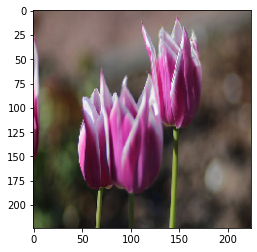

In [ ]:
%matplotlib inline

# Check tflite model
def set_input_tensor(interpreter, input):
  input_details = interpreter.get_input_details()[0]
  tensor_index = input_details['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  scale, zero_point = input_details['quantization']
  input_tensor[:, :] = np.uint8(input / scale + zero_point)

def classify_image(interpreter, input):
  set_input_tensor(interpreter, input)
  interpreter.invoke()
  output_details = interpreter.get_output_details()[0]
  output = interpreter.get_tensor(output_details['index'])
  scale, zero_point = output_details['quantization']
  output = scale * (output - zero_point)
  return np.argmax(output), max(output[0])

interpreter = tf.lite.Interpreter('/content/model/efficientnet_224_quant.tflite')
interpreter.allocate_tensors()

batch_prediction = []
batch_truth = np.argmax(batch_labels, axis=1)
for i in range(len(batch_images)):
  plt.imshow(batch_images[i])
  plt.show()
  prediction, score = classify_image(interpreter, batch_images[i])
  print(labels[prediction], score, '\n')
  batch_prediction.append(prediction)

# Compare all predictions to the ground truth
tflite_accuracy = tf.keras.metrics.Accuracy()
tflite_accuracy(batch_prediction, batch_truth)
print('-------------------')
print("Quant TF Lite accuracy: {:.3%}".format(tflite_accuracy.result()))


In [ ]:
# Install edgetpu compiler
! curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
! echo "deb https://packages.cloud.google.com/apt coral-edgetpu-stable main" | sudo tee /etc/apt/sources.list.d/coral-edgetpu.list
! sudo apt-get update
! sudo apt-get install edgetpu-compiler	

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   653  100   653    0     0  15186      0 --:--:-- --:--:-- --:--:-- 15547
OK
deb https://packages.cloud.google.com/apt coral-edgetpu-stable main
Get:1 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:5 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran3

In [ ]:
# Compile the model
%cd /content/model
!edgetpu_compiler -s efficientnet_224_quant.tflite

/content/model
Edge TPU Compiler version 14.1.317412892

Model compiled successfully in 5527 ms.

Input model: efficientnet_224_quant.tflite
Input size: 7.83MiB
Output model: efficientnet_224_quant_edgetpu.tflite
Output size: 8.55MiB
On-chip memory used for caching model parameters: 4.62MiB
On-chip memory remaining for caching model parameters: 1.25KiB
Off-chip memory used for streaming uncached model parameters: 3.16MiB
Number of Edge TPU subgraphs: 1
Total number of operations: 366
Operation log: efficientnet_224_quant_edgetpu.log

Operator                       Count      Status

FULLY_CONNECTED                1          Mapped to Edge TPU
QUANTIZE                       2          Mapped to Edge TPU
MUL                            92         Mapped to Edge TPU
CONV_2D                        92         Mapped to Edge TPU
DEPTHWISE_CONV_2D              23         Mapped to Edge TPU
RESHAPE                        23         Mapped to Edge TPU
MEAN                           24         Ma

In [ ]:
# Package everything and then download it
%cd /content
!tar cvf model.tar.gz model
from google.colab import files
files.download('model.tar.gz')

/content
model/
model/flower_labels.txt
model/efficientnet_224_quant_edgetpu.tflite
model/efficientnet_224_quant_edgetpu.log
model/efficientnet_224_quant.tflite


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>